# Plots for evaluating time/value of partitioning/order reduction
Sandbox and playground for evaluating how compute time and value changes as we either partition or reduce order of relu programs

steps here: 
1. Set up some relu programs 
2. Build tools to plot partitioning time/vals 
3. Build tools to plot order reduction time/vals 

In [1]:
# Basic import block 
import sys

sys.path.append('..')
import math
import random
import time
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from abstract_domains import Hyperbox, Zonotope
from neural_nets import FFNet, PreactBounds, KWBounds
import train
import utilities
import dual_naive as dn
import dual_decompose as dd 
import pickle
import seaborn as sns 
sns.set()
import lp_relaxation as lpr

valsum = lambda d: sum(d.values()) # handy little function
flatten = lambda lol: [subel for sublist in lol for subel in sublist]

torch.manual_seed(42)

# Part 1: Set up ReLU programs

In [2]:
### Load and train a net
# Simple [784, 256, 128, 64, 10] PGD-trained MNIST network

make_net = lambda: FFNet(
                    nn.Sequential(nn.Linear(784, 256), 
                    nn.ReLU(), 
                    nn.Linear(256, 128), 
                    nn.ReLU(), 
                    nn.Linear(128, 64), 
                    nn.ReLU(), 
                    nn.Linear(64, 10)))


adv_net = make_net() # Make network

mnist_train = train.load_mnist_data('train', batch_size=128) # load datasets
mnist_val = train.load_mnist_data('val')


headless_atk = train.PGD(None, float('inf'), 0.1, 10, lb=0.0, ub=1.0) #setup attack params
advtrain_params = train.TrainParameters(mnist_train, mnist_val, 10, adv_attack=headless_atk) # setup train params


try: # Try to load the pickled network, otherwise train it
    adv_net = pickle.load(open('../pickles/adv_net.pkl', 'rb'))
except:
    train.training_loop(adv_net, advtrain_params)
    pickle.dump(adv_net, open('../pickles/adv_net.pkl', 'wb'))
    train.test_validation(adv_net, advtrain_params)

advtrain_params.adv_attack = train.PGD(adv_net, float('inf'), 0.1, 10, lb=0.0, ub=1.0)
print('Clean acc: %.2f; Robust acc: %.2f' % train.test_validation(adv_net, advtrain_params)[1:])

Clean acc: 97.81; Robust acc: 87.38


tensor([[0.4137]], grad_fn=<AddmmBackward>)


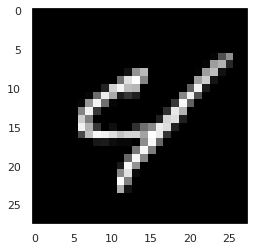

In [3]:
'''
Now convert network to a binary classifier: (can only do binary classifier certification).
We'll do the following jointly:
- pick an MNIST example to certify 
- build the Hyperbox that defines the adversarial input region (what the adv can do)
- build a Binary classifier of <label> vs <label + 1>  (e.g., if the example is a 7, this is a 7vs8 classifier)
'''


IDX = 420
def setup_ex(network, rad, idx=IDX): # handy function that does the steps above^
    # Returns bin_net, input_domain 
    
    MNIST_dataset = datasets.MNIST(train.DEFAULT_DATASET_DIR, train=False, 
                                   download=True, transform=transforms.ToTensor())
    
    x, label = MNIST_dataset[idx]
    utilities.show_grayscale(x)
    
    test_box = Hyperbox.linf_box(x.view(-1), rad) 
    ypred = network(x.view(1, -1)).max(dim=1)[1].item()
    
    bin_net = network.binarize(ypred, ((ypred +1) % 10))
    return bin_net, test_box


RAD = 0.1
test_ex = next(iter(mnist_val))[0][20].view(-1) #Just pick an arbitrary example
bin_net, test_input = setup_ex(adv_net, RAD)
#test_input = test_input.clamp(0.0, 1.0)
print(bin_net(test_ex.view(1, 28, 28)))

In [4]:
dual_zono = dn.NaiveDual(bin_net, test_input, preact_domain=Zonotope, choice='naive')
optimizer = optim.Adam(dual_zono.parameters(), lr=1e-2)
dual_zono.dual_ascent(500, optim_obj=optimizer, verbose=50)

Iter 00 | Certificate: -49.09
Iter 50 | Certificate: -50.81
Iter 100 | Certificate: -49.27
Iter 150 | Certificate: -48.51
Iter 200 | Certificate: -47.04
Iter 250 | Certificate: -46.55
Iter 300 | Certificate: -46.53
Iter 350 | Certificate: -46.50
Iter 400 | Certificate: -46.15
Iter 450 | Certificate: -46.29


tensor(-46.2411, grad_fn=<AddBackward0>)

In [5]:
def get_ith_rp(dual_obj, idx):
    # Returns (zono, c1, c2) for ReluProgram
    bounds = dual_obj.preact_bounds[idx]
    assert isinstance(bounds, Zonotope)
    return (bounds, dual_obj.lambda_[idx - 1], -dual_obj.lambda_[idx])
                                               
def get_rps(dual_obj):
    outputs =[]
    for i, el in enumerate(dual_obj.network):
        if i % 2 == 1:
            outputs.append(get_ith_rp(dual_obj, i))
    return outputs

rps = get_rps(dual_zono)

# Partition Graphs

In [6]:
def partition_series_vals(zono, c1, c2, part_dim_iter):
    """ Groups ReLU programs into partitions specified by part_dim_iter
        Returns list of [(part_dim, time, time-MIPsetup, value),...]
    where part_dim refers to dimension of each partition element 
    """
    outputs = [] 
    for part_dim in part_dim_iter:
        print("Working on partitions of dimension %s" % part_dim)
        part = zono.make_random_partitions_dim(part_dim)
        runsum = 0
        start = time.time()
        for group, subzono in part:
            subzono._setup_relu_mip()
        post_mip_setup_start = time.time()
        for group, subzono in part:
            runsum += subzono.solve_relu_mip(c1[group], c2[group])[0]
        outputs.append((part_dim, time.time() - start, time.time() - post_mip_setup_start, runsum))
    return outputs

def plot_partition_series_vals(data, ax=None, logtime=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    
    time_xform = (lambda x: math.log(x, 10)) if logtime else (lambda x: x)
    time_ax = ax.twinx()
    ln1 = time_ax.plot([_[0] for _ in data], [time_xform(_[1]) for _ in data], c='b', label='Time')
    ln2 = time_ax.plot([_[0] for _ in data], [time_xform(_[2]) for _ in data], c='r', label='Post MIP setup Time')
    ln3 = ax.plot([_[0] for _ in data], [_[3] for _ in data], c='g', label='Values')
    ax.set_xlabel('Partition Dimension')
        
    lns = ln1 + ln2 + ln3
    time_ax.set_ylabel('Time')
    ax.set_ylabel('Value')
    ax.legend(lns, [l.get_label() for l in lns])
    return ax



In [ ]:
rp2_data = partition_series_vals(*rps[2], [1,2,4,8,16,32])

Working on partitions of dimension 1
Using license file /home/matt/config/gurobi.lic
Academic license - for non-commercial use only


In [ ]:
plot_partition_series_vals(rp2_data)

# Order reduction Graphs

In [ ]:
def order_series_vals(zono, c1, c2, num_steps, **reduce_kwargs):
    # Linearly interpolates between 1->order(zono) in (num_steps+1) steps
    # Returns list of [(order, total_time, mipSolve_time, value)]
    inc = (zono.order - 1) / num_steps
    orders = [1 + inc * i for i in range(num_steps)]
    outputs = [] 
    for order in orders:
        total_start = time.time()
        redux_zono = zono.reduce_simple(order, **reduce_kwargs)
        print("Trying order %s" % redux_zono.order)

        redux_zono._setup_relu_mip()
        
        mip_start = time.time()
        val = redux_zono.solve_relu_mip(c1, c2)[0]
        outputs.append((order, time.time() - total_start, time.time() - mip_start, val))
    return outputs

def get_single_part(zono, c1, c2, dim):
    group, subzono = zono.make_random_partitions_dim(dim)[0]
    return subzono, c1[group], c2[group]
    
def plot_order_series_vals(data, ax=None, logtime=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    
    
    time_xform = (lambda x: math.log(x, 10)) if logtime else (lambda x: x)
    time_ax = ax.twinx()
    ln1 = time_ax.plot([_[0] for _ in data], [time_xform(_[1]) for _ in data], c='b', label='Time')
    ln2 = time_ax.plot([_[0] for _ in data], [time_xform(_[2]) for _ in data], c='r', label='Post MIP setup Time')
    ln3 = ax.plot([_[0] for _ in data], [_[3] for _ in data], c='g', label='Values')
    ax.set_xlabel('Order')
    ax.set_ylabel('Value')
    time_ax.set_ylabel('Time')
    
    lns = ln1 + ln2 + ln3
    ax.legend(lns, [l.get_label() for l in lns], loc=0)

    return ax


In [ ]:
# Make reduced partition for speed purposes...
sp_zono, sp_c1, sp_c2 = get_single_part(*rps[2], 32)
order_data = order_series_vals(sp_zono, sp_c1, sp_c2, 32)
plot_order_series_vals(order_data)